# Лингвистическое моделирование на уровне символов

## Предсказание на основе последнего символа

In [ ]:
import torch

with open("./data/names.txt", "r", encoding="utf-8") as f:
    words = f.read().splitlines()

special_tokens = ["<S>", "<E>"]
chars_pool = sorted(list(set("".join(words))))
alphabet = chars_pool + special_tokens
alphabet_mapping = {ch: i for i, ch in enumerate(alphabet)}

### Bigram model

In [4]:
bigram_matrix = torch.zeros(size=(len(alphabet), len(alphabet)), dtype=torch.int32)
for w in words:
    chrs = [special_tokens[0]] + list(w) + [special_tokens[1]]
    for ch1, ch2 in zip(chrs, chrs[1:]):
        i1, i2 = alphabet_mapping[ch1], alphabet_mapping[ch2]
        bigram_matrix[i1, i2] += 1
bigram_matrix

tensor([[ 556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568, 2528,
         1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,  182,
         2050,  435,    0, 6640],
        [ 321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,  103,
            0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,    0,
           83,    0,    0,  114],
        [ 815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,  116,
            0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,    3,
          104,    4,    0,   97],
        [1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,   60,
           30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,    0,
          317,    1,    0,  516],
        [ 679,  121,  153,  384, 1271,   82,  125,  152,  818,   55,  178, 3248,
          769, 2675,  269,   83,   14, 1958,  861,  580,   69,  463,   50,  132,
         1070,  181,    0, 3983],
        [ 242,    0,

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

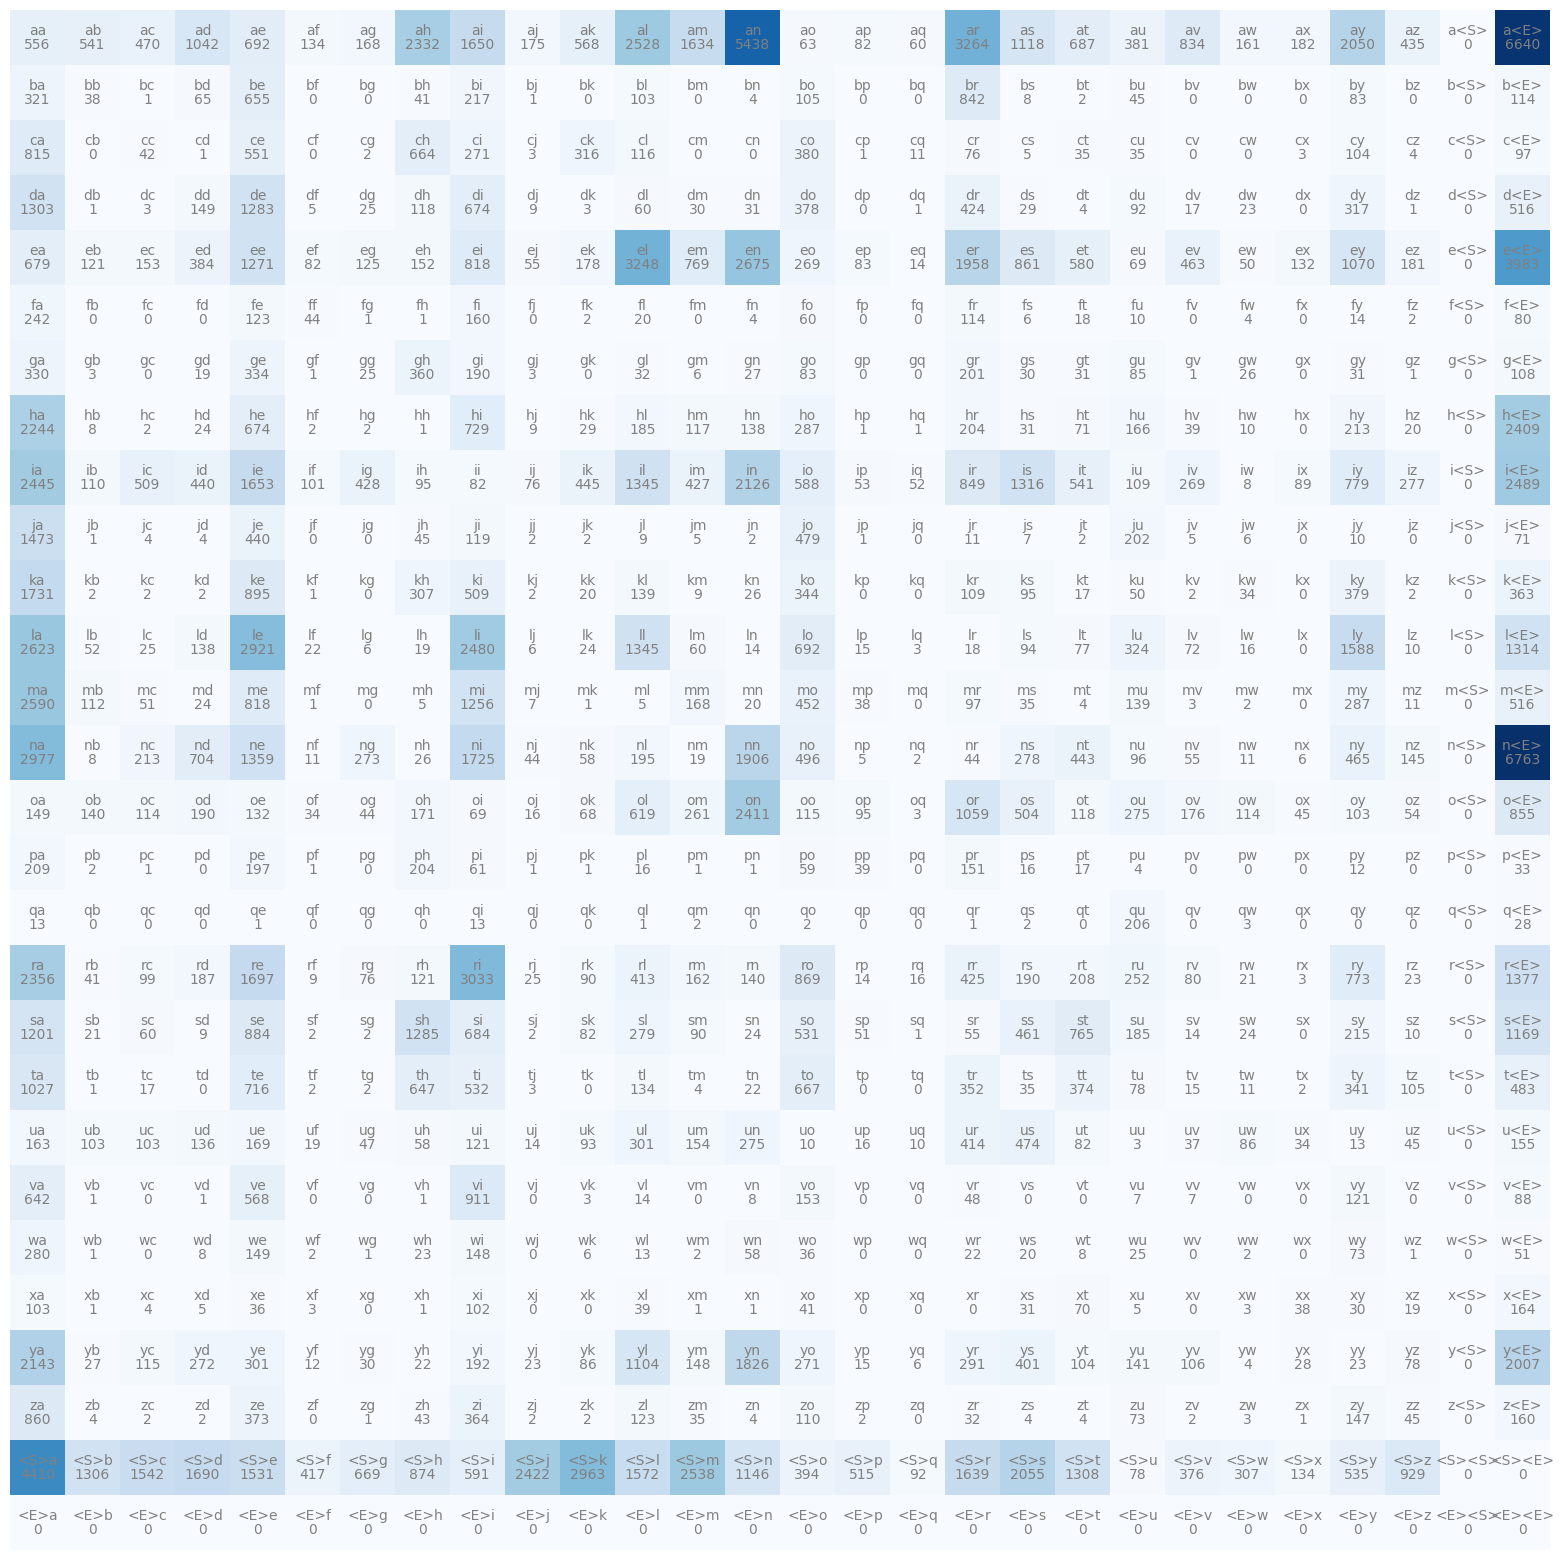

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
plt.imshow(bigram_matrix, cmap="Blues")
for i in range(len(alphabet)):
    for j in range(len(alphabet)):
        label = alphabet[i] + alphabet[j]
        plt.text(j, i, label, ha="center", va="bottom", color="gray")
        plt.text(j, i, bigram_matrix[i, j].item(), ha="center", va="top", color="gray")
plt.axis("off")

In [6]:
gen = torch.Generator().manual_seed(42)

smoothed_matrix = bigram_matrix.float() + 1  # Сглаживание
distribution_matrix = smoothed_matrix / smoothed_matrix.sum(dim=1, keepdim=True)
# distribution_matrix = torch.nan_to_num(distribution_matrix, nan=0.)
distribution_matrix

tensor([[1.6424e-02, 1.5982e-02, 1.3888e-02, 3.0755e-02, 2.0435e-02, 3.9808e-03,
         4.9833e-03, 6.8794e-02, 4.8683e-02, 5.1898e-03, 1.6778e-02, 7.4573e-02,
         4.8212e-02, 1.6038e-01, 1.8872e-03, 2.4474e-03, 1.7987e-03, 9.6276e-02,
         3.2996e-02, 2.0287e-02, 1.1264e-02, 2.4622e-02, 4.7769e-03, 5.3962e-03,
         6.0478e-02, 1.2856e-02, 2.9487e-05, 1.9582e-01],
        [1.2046e-01, 1.4590e-02, 7.4822e-04, 2.4691e-02, 2.4542e-01, 3.7411e-04,
         3.7411e-04, 1.5713e-02, 8.1556e-02, 7.4822e-04, 3.7411e-04, 3.8908e-02,
         3.7411e-04, 1.8706e-03, 3.9656e-02, 3.7411e-04, 3.7411e-04, 3.1538e-01,
         3.3670e-03, 1.1223e-03, 1.7209e-02, 3.7411e-04, 3.7411e-04, 3.7411e-04,
         3.1425e-02, 3.7411e-04, 3.7411e-04, 4.3023e-02],
        [2.2921e-01, 2.8090e-04, 1.2079e-02, 5.6180e-04, 1.5506e-01, 2.8090e-04,
         8.4270e-04, 1.8680e-01, 7.6404e-02, 1.1236e-03, 8.9045e-02, 3.2865e-02,
         2.8090e-04, 2.8090e-04, 1.0702e-01, 5.6180e-04, 3.3708e-03, 2.162

In [7]:
for _ in range(10):
    cur_token, predicted = "<S>", []  # Всегда начинаем с токена старта
    while cur_token != "<E>":
        chr_i = torch.multinomial(
            distribution_matrix[alphabet_mapping[cur_token], :], 
            num_samples=1, 
            replacement=True, 
            generator=gen,
        ).item()
        cur_token = alphabet[chr_i]
        predicted.append(cur_token)

    print("".join(predicted[:-1]))

za
t
brina
joremycllina
ha
zraush
reydixon
beaemareljanaialen
tarera
pan


In [8]:
loss = -(bigram_matrix * torch.log(distribution_matrix)).sum() / bigram_matrix.sum()  # negative log likelihood
print(f"loss:", loss.item())

loss: 2.454693555831909


### Neural Network

In [13]:
import torch.nn.functional as F

xs, ys = [], []
for w in words[:]:
    chrs = [special_tokens[0]] + list(w) + [special_tokens[1]]
    for chr1, chr2 in zip(chrs, chrs[1:]):
        xs.append(alphabet_mapping[chr1])
        ys.append(alphabet_mapping[chr2])

xs, ys = torch.tensor(xs), torch.tensor(ys)
train_data = F.one_hot(xs, num_classes=len(alphabet)).float()

weights = torch.randn(size=(len(alphabet), len(alphabet)), requires_grad=True)
gen = torch.Generator().manual_seed(42)

In [ ]:
epoches = 100
lr = 100
batch_size = 8192
l2 = 0.01  # Регуляризация

for epoch in range(1, epoches + 1):
    # logits = train_data @ weights
    # exp_logits = logits.exp()
    # probs = exp_logits / exp_logits.sum(dim=1, keepdim=True)  # soft-max
    # loss = -probs[:, ys].log().mean() + l2 * (weights ** 2).mean()
    # weights.grad = None
    # loss.backward()
    # weights.data += -lr * weights.grad

    losses = []
    for _ in range(len(train_data) // batch_size):
        obj_indexes = torch.randint(
            low=0, 
            high=len(train_data), 
            size=(batch_size, ), 
            generator=gen,
        )
        batch_x = train_data[obj_indexes, :]
        batch_y = ys[obj_indexes]
        
        logits = batch_x @ weights
        exp_logits = logits.exp()
        probs = exp_logits / exp_logits.sum(dim=1, keepdim=True)  # soft-max
        loss = -probs[:, batch_y].log().mean() + l2 * (weights ** 2).mean()

        weights.grad = None
        loss.backward()
        weights.data += -lr * weights.grad
        
        losses.append(loss.item())

    print(f"{epoch=}, mean_loss={sum(losses) / len(losses)}")

In [ ]:
for _ in range(10):
    cur_token, predicted = "<S>", []  # Всегда начинаем с токена старта
    while cur_token != "<E>":
        vec = F.one_hot(
            torch.tensor([alphabet_mapping[cur_token]]), 
            num_classes=len(alphabet),
        ).float()
        logits = vec @ weights
        exp_logits = logits.exp()
        probs = exp_logits / exp_logits.sum(dim=1, keepdim=True)
        chr_i = torch.multinomial(
            probs, 
            num_samples=1, 
            replacement=True, 
            generator=gen,
        ).item()

        cur_token = alphabet[chr_i]
        predicted.append(cur_token)

    print("".join(predicted[:-1]))

In [ ]:
logits = train_data @ weights
exp_logits = logits.exp()
probs = exp_logits / exp_logits.sum(dim=1, keepdim=True)
loss = -probs[:, ys].log().mean().item()
print(f"{loss=}")

## Предсказание на основе контекста

In [1]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
words = open("./data/names.txt", "r").read().splitlines()
alphabet = sorted(list(set("".join(words))))
chr2i = {ch : i for i, ch in enumerate(alphabet, 1)}
chr2i["."] = 0
i2chr = {i : ch for ch, i in chr2i.items()}

In [3]:
import random
random.seed(42)

context_size = 3

def build_dataset(words, device = "cpu"):
    X, Y = [], []
    for word in words[:]:
        context = [chr2i["."]] * context_size
        for ch in word + ".":
            cur_token = chr2i[ch]
            X.append(context)
            Y.append(cur_token)
            context = context[1:] + [cur_token]

    X, Y = torch.tensor(X, device=device), torch.tensor(Y, device=device)
    
    return X, Y


random.shuffle(words)

n1, n2 = int(len(words) * 0.8), int(len(words) * 0.9)

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1 : n2], device=device)
X_test, Y_test = build_dataset(words[n2:], device=device)

### Multi Layered Perceptron

#### A Neural Probabilistic Language Model - Journal of Machine Learning Research 3 (2003) 1137–1155 - Yoshua Bengio,  Réjean Ducharme, Pascal Vincent, Christian Jauvin


#### Инициализация с применением некоторых техник после анализа поведения при обучении

In [ ]:
g = torch.Generator(device).manual_seed(42)
g_cpu = torch.Generator().manual_seed(42)

embedding_dimension = 16
hidden_layer = 200
n_tokens = len(chr2i)

C = torch.randn((n_tokens, embedding_dimension), device=device, generator=g)  # Матрица эмбеддингов размерностью n_tokens х embedding_dimension

bn_gain = torch.ones((1, hidden_layer), device=device)  # Параметры для batch-norm (bn)
bn_bias = torch.zeros((1, hidden_layer), device=device)  # Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift - Google Inc. (2015)

W1 = torch.nn.init.kaiming_uniform_(
    torch.zeros(embedding_dimension * context_size, hidden_layer), 
    nonlinearity="tanh", 
    generator=g_cpu,  # Не принимает генераторы на cuda
).to(device)  # Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification - He, K. et al. (2015)
# При батч-нормализации не имеет смысла добавлять смещение в линейном слое, т.к при нормализации b1 просто теряет свой вклад и у bn есть свое смещение
# b1 = torch.randn(hidden_layer, device=device, generator=g) * 0.01 
W2 = torch.randn((hidden_layer, n_tokens), device=device, generator=g) * 0.01
b2 = torch.zeros(n_tokens, device=device)

bn_mean_running = torch.zeros((1, hidden_layer), device=device)
bn_std_running = torch.ones((1, hidden_layer), device=device)

# parameters = [C, W1, b1, W2, b2]
parameters = [C, W1, W2, b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

15459

#### Изучение распределения весов

In [ ]:
# Мини-батч
batch_size = 32
ix = torch.randint(0, X_train.shape[0], (batch_size, ))  # Индексы объектов для мини-батча
x, y = X_train[ix], Y_train[ix].to(device)

# Прямой проход
h = torch.tanh(C[x].view(-1, embedding_dimension * context_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y)

# Обратный проход
for p in parameters:
    p.grad = None
loss.backward()

loss.item()  

# W2 = torch.randn((hidden_layer, n_tokens), device=device, generator=g) * 0.01
# Изначально, в первые эпохи значение loss было около 15-25 
# Благодаря домножению на коэффициент 0.01 при инициализации мы пропускаем эпохи, когда веса просто уменьшаются

3.297614097595215

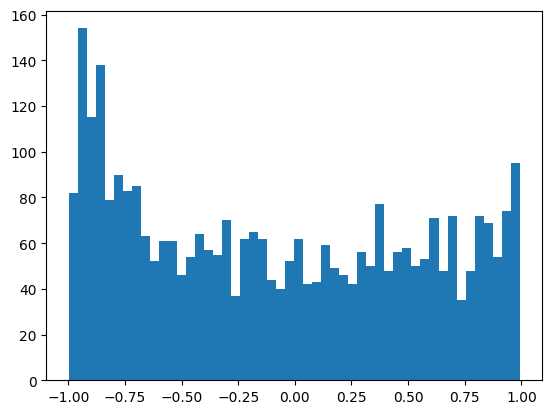

In [ ]:
# Гистограмма распределения значений после активации tanh
plt.hist(h.to("cpu").storage().tolist(), 50)
plt.show()

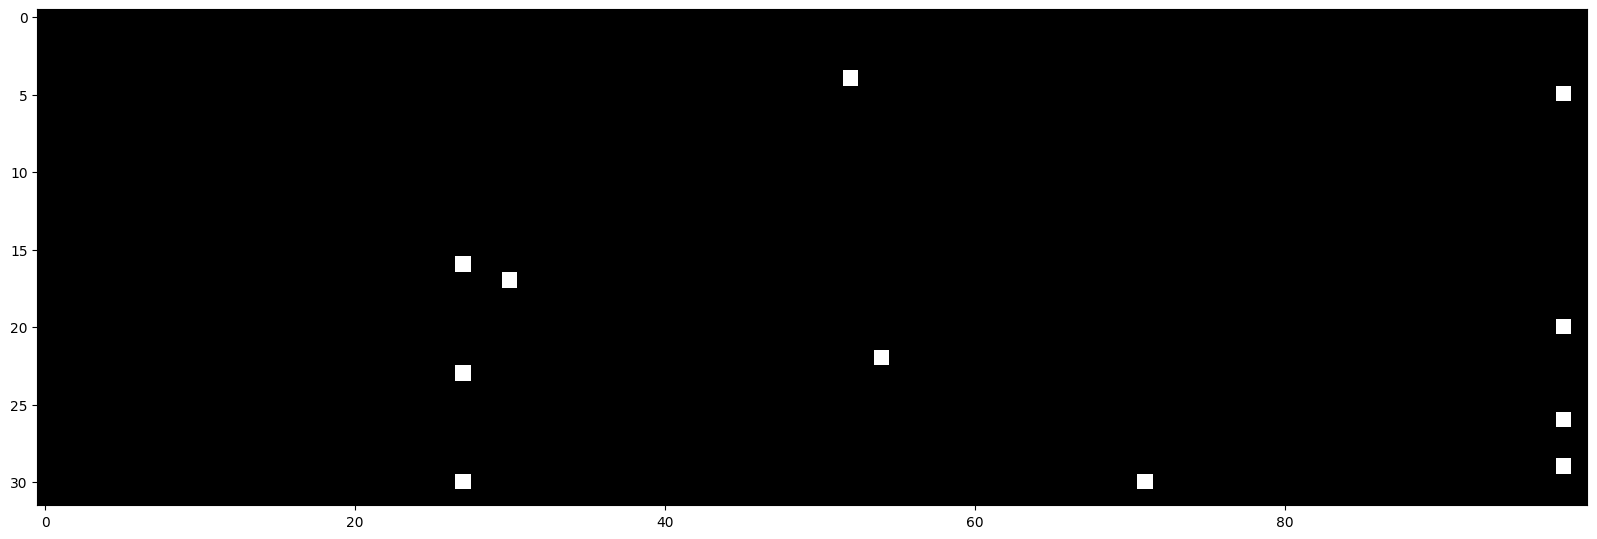

In [ ]:
# Визуализация нейронов, у которых не обновятся значения
# во время backprop из-за выхода на "плато" функции tanh
# (Белые точки - true)
# Исходит из производной функции активации (1 - t^2), где t - значение tanh(x)
plt.figure(figsize=(20, 10))
plt.imshow(h.to("cpu").abs() > 0.99, cmap="gray", interpolation="nearest")

#### Подбор скорости обучения

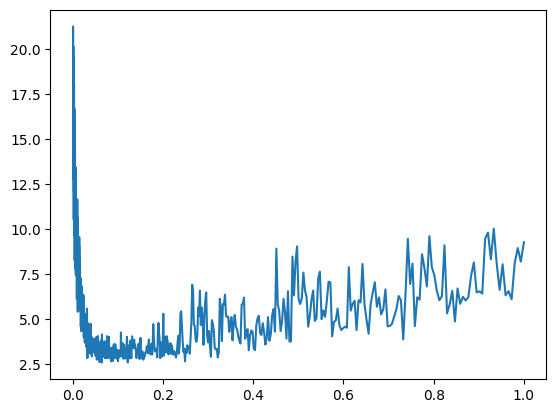

In [ ]:
epoches = 1000
batch_size = 32
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre
losses = []
for epoch in range(epoches):
    # Мини-батч
    ix = torch.randint(0, X_train.shape[0], (batch_size, ))  # Индексы объектов для мини-батча
    x, y = X_train[ix], Y_train[ix].to(device)

    # Прямой проход
    h = torch.tanh(C[x].view(-1, embedding_dimension * context_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)

    # Обратный проход
    for p in parameters:
        p.grad = None
    loss.backward()

    # Обновление параметров
    for p in parameters:
        p.data -= p.grad * lrs[epoch] 

    # Сохранение истории
    losses.append(loss.item())

plt.plot(lrs[:len(losses)], losses)
plt.show()

#### Train-loop

In [ ]:
epoches = 100000
lr = 0.05
batch_size = 64
for epoch in range(epoches):
    # Прямой проход
    
    ## Мини-батч
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g_cpu)  # Индексы объектов для мини-батча
    x, y = X_train[ix], Y_train[ix].to(device)

    h_preact = C[x].view(-1, embedding_dimension * context_size) @ W1
    
    ## Батч-нормализация
    b_mean = h_preact.mean(dim=0, keepdim=True)
    b_std = h_preact.std(dim=0, keepdim=True)
    h_normed = bn_gain * ((h_preact - b_mean) / b_std) + bn_bias
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * b_mean
        bn_std_running = 0.999 * bn_std_running + 0.001 * b_std

    logits = torch.tanh(h_normed) @ W2 + b2
    loss = F.cross_entropy(logits, y)

    # Обратный проход
    for p in parameters:
        p.grad = None
    loss.backward()

    # Обновление параметров
    for p in parameters:
        p.data -= p.grad * lr 

    if epoch % 10000 == 0:
        print(f"{epoch=}; TRAIN loss={loss.item()}")
    
    # Валидация
    if epoch % (X_train.shape[0] // batch_size) == 0:  # Ожидается, что мы пройдем по всему набору данных
        with torch.no_grad():
            h_preact = C[X_dev].view(-1, embedding_dimension * context_size) @ W1
            h_normed = bn_gain * ((h_preact - h_preact.mean(dim=0, keepdim=True)) / h_preact.std(dim=0, keepdim=True)) + bn_bias
            logits = torch.tanh(h_normed) @ W2 + b2
            loss = F.cross_entropy(logits, Y_dev)
            print(f"{epoch=}; VALIDATION loss={loss.item()}")

epoch=0; TRAIN loss=3.315398931503296
epoch=0; VALIDATION loss=3.285687208175659
epoch=2853; VALIDATION loss=2.2904934883117676
epoch=5706; VALIDATION loss=2.244951009750366
epoch=8559; VALIDATION loss=2.2272748947143555
epoch=10000; TRAIN loss=2.1705398559570312
epoch=11412; VALIDATION loss=2.2088520526885986
epoch=14265; VALIDATION loss=2.1918938159942627
epoch=17118; VALIDATION loss=2.198802947998047
epoch=19971; VALIDATION loss=2.1781129837036133
epoch=20000; TRAIN loss=2.269944429397583
epoch=22824; VALIDATION loss=2.1782169342041016
epoch=25677; VALIDATION loss=2.1715424060821533
epoch=28530; VALIDATION loss=2.1578354835510254
epoch=30000; TRAIN loss=2.101374626159668
epoch=31383; VALIDATION loss=2.1543805599212646
epoch=34236; VALIDATION loss=2.155278205871582
epoch=37089; VALIDATION loss=2.1501169204711914
epoch=39942; VALIDATION loss=2.1553115844726562
epoch=40000; TRAIN loss=1.9692078828811646
epoch=42795; VALIDATION loss=2.143904209136963
epoch=45648; VALIDATION loss=2.14125

In [7]:
with torch.no_grad():
    h_preact = C[X_test].view(-1, embedding_dimension * context_size) @ W1
    h_normed = bn_gain * ((h_preact - bn_mean_running) / bn_std_running) + bn_bias
    logits = torch.tanh(h_normed) @ W2 + b2
    loss = F.cross_entropy(logits, Y_test)
loss.item()

2.1275973320007324

#### Визуализация эмбеддингов (только при embedding_dimension=2)

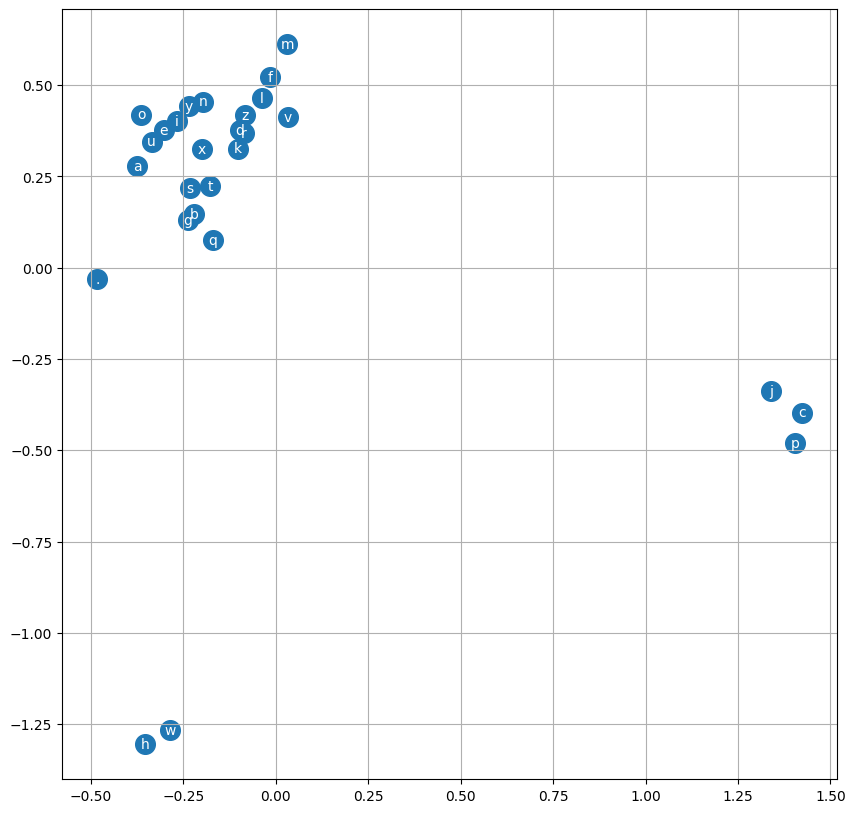

In [15]:
emb_table = C.to("cpu")
plt.figure(figsize=(10, 10))
plt.scatter(emb_table[:, 0].data, emb_table[:, 1].data, s=200)
for i in range(n_tokens):
    plt.text(emb_table[i, 0].item(), emb_table[i, 1].item(), i2chr[i], ha="center", va="center", color="white")
plt.grid("minor")
plt.show()

#### Инференс

In [8]:
g = torch.Generator(device).manual_seed(42)

for _ in range(20):
    out = []
    context = [0] * context_size
    while True:
        emb = C[torch.tensor([context])]

        h_preact = emb.view(1, -1) @ W1
        h_normed = bn_gain * ((h_preact - bn_mean_running) / bn_std_running) + bn_bias
        logits = torch.tanh(h_normed) @ W2 + b2
        
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        if ix == 0:
            break
        context = context[1:] + [ix]
        out.append(ix)
    
    print("".join(i2chr[i] for i in out))

krita
eilyn
ange
dagar
ever
mair
shiponaikellivi
brylin
muhgamier
diyan
ion
uluci
cher
tin
millyheston
mir
wesy
kah
cidet
don


### Torch-подобный код для MLP

#### Обучение

In [ ]:
from src.handmade_torch_nn import (
    Linear,
    BatchNorm1d,
    Tanh,
)  # Классы, подобные описанным в torch.nn


g = torch.Generator(device=device).manual_seed(42)
g_cpu = torch.Generator().manual_seed(42)

hidden_layer = 100
n_tokens = len(i2chr)
embedding_dimension = 16

C = torch.randn((n_tokens, embedding_dimension), device=device, generator=g)
layers = [
    Linear(embedding_dimension * context_size, hidden_layer, bias=False, device=device), BatchNorm1d(hidden_layer, device=device), Tanh(),
    Linear(hidden_layer, hidden_layer, bias=False, device=device), BatchNorm1d(hidden_layer, device=device), Tanh(),
    Linear(hidden_layer, hidden_layer, bias=False, device=device), BatchNorm1d(hidden_layer, device=device), Tanh(),
    Linear(hidden_layer, hidden_layer, bias=False, device=device), BatchNorm1d(hidden_layer, device=device), Tanh(),
    Linear(hidden_layer, n_tokens, bias=False, device=device), BatchNorm1d(n_tokens, device=device)
]

with torch.no_grad():
    layers[-1].gamma *= 0.1

    init_coef = torch.nn.init.calculate_gain("tanh")
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= init_coef


parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

38786

In [31]:
epoches = 10000
batch_size = 64
losses, uds = [], []
for epoch in range(epoches):
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g_cpu)
    x, y = X_train[ix], Y_train[ix].to(device)

    embeddings = C[x]
    x = embeddings.view(-1, context_size * embedding_dimension)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)

    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.05 if epoch < 50000 else 0.025
    for p in parameters:
        p.data -= lr * p.grad
    
    if epoch % 5000 == 0:
        print(f"{epoch=}; loss={loss.item():.4f}")
    
    losses.append(loss.log10().item())
    with torch.no_grad():
        uds.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

epoch=0; loss=3.3066
epoch=5000; loss=2.1860


#### Визуализации после первой итерации

mean: -0.0528, std: 0.7599, saturated: 22.6406%
mean: 0.0139, std: 0.7079, saturated: 10.7500%
mean: 0.0326, std: 0.7016, saturated: 9.0938%
mean: 0.0190, std: 0.7021, saturated: 8.9844%


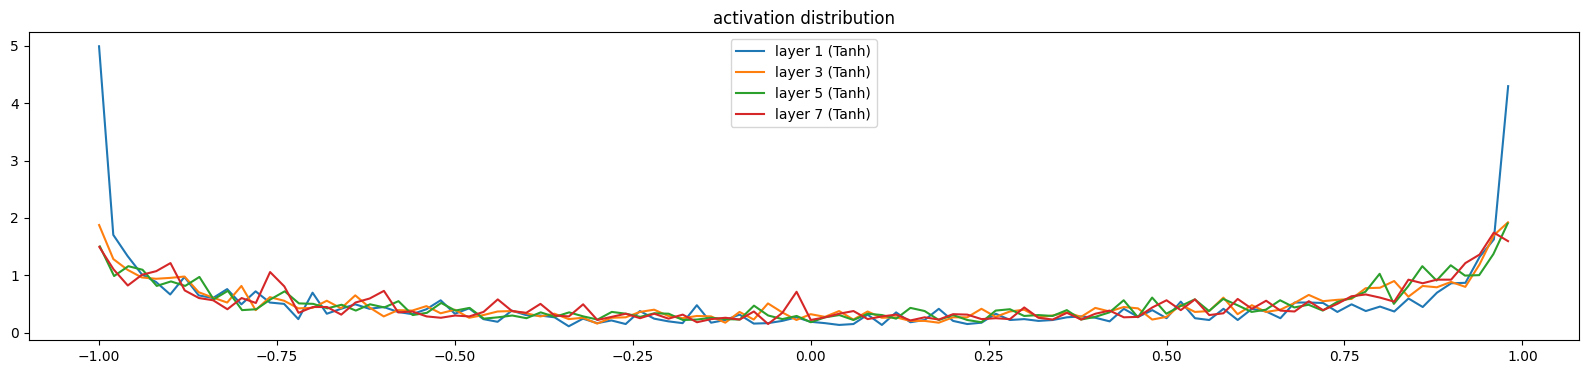

In [22]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.to("cpu")
        print(f"mean: {t.mean() :.4f}, std: {t.std() :.4f}, saturated: {(t.abs() > 0.97).float().mean() * 100 :.4f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distribution")
plt.show()

mean: -0.0000, std: 0.0001, saturated: 0.0000%
mean: -0.0000, std: 0.0001, saturated: 0.0000%
mean: 0.0000, std: 0.0001, saturated: 0.0000%
mean: 0.0000, std: 0.0001, saturated: 0.0000%


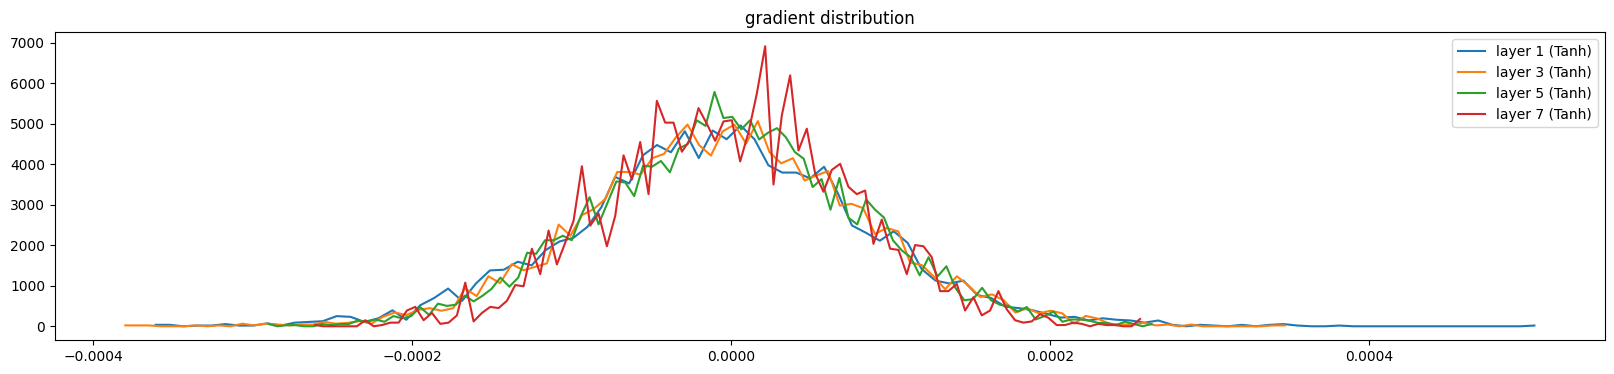

In [ ]:
# Хороший случай без затухания градиента. На каждом слое все градиенты имеют примерно одно значение
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad.to("cpu")
        print(f"mean: {t.mean() :.4f}, std: {t.std() :.4f}, saturated: {(t.abs() > 0.97).float().mean() * 100 :.4f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("gradient distribution")
plt.show()

#### Визуализация отношения длины шага к величине параметра

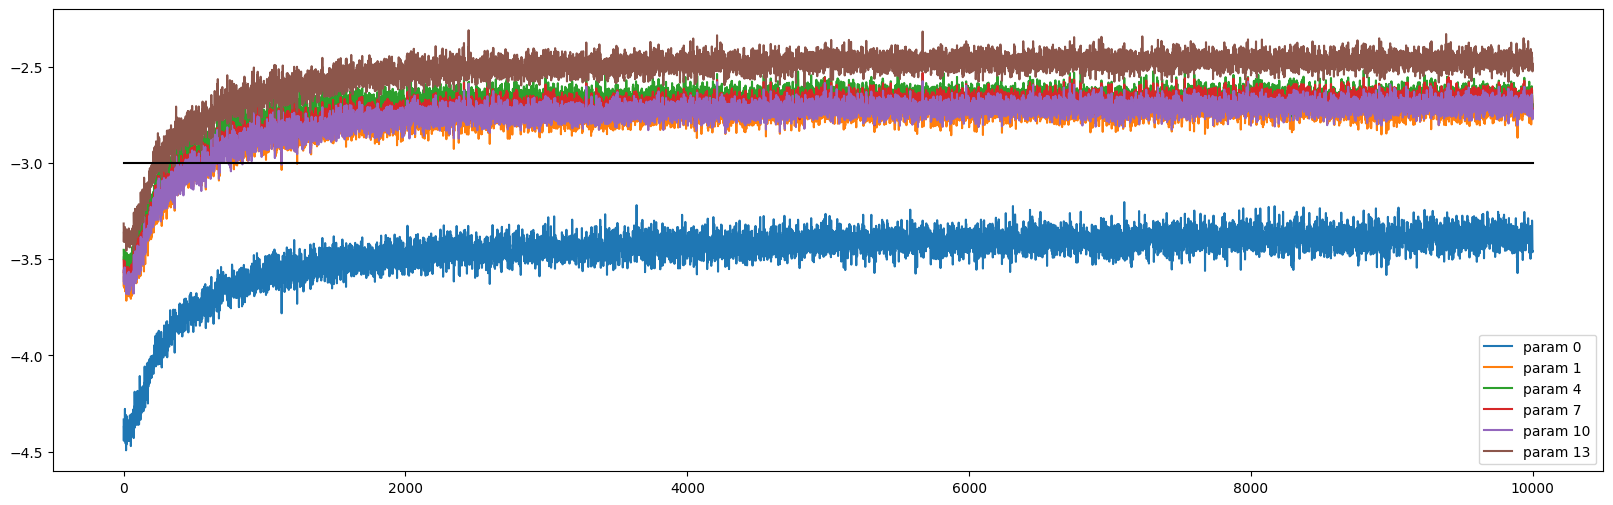

In [32]:
plt.figure(figsize=(20, 6))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([uds[j][i] for j in range(len(uds))])
        legends.append(f"param {i}")
plt.plot([0, len(uds)], [-3, -3], "k")  # В uds лежат log10(x) значения. Принимаем за оптимальное отношение длины шага к величине параметра 1e-3. Т.е. lg(1e-3) = 3
plt.legend(legends)
plt.show()

### WaveNet

### Упражнения на понимание обратного распространения

In [4]:
def compare(s, dt, tnsr):  # Функция для сравнения наших градиентов с вычисленными на torch
    ex = torch.all(dt == tnsr.grad).item()
    app = torch.allclose(dt, tnsr.grad)
    maxdiff = (dt - tnsr.grad).abs().max().item()
    print(f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}")

In [71]:
embedding_dimension = 10
hidden_layer = 64
n_tokens = len(chr2i)

g = torch.Generator(device).manual_seed(42)
g_cpu = torch.Generator().manual_seed(42)

params = {"generator": g, "device": device, "requires_grad": True}

C = torch.randn((n_tokens, embedding_dimension), **params)

W1 = (
    torch.randn((embedding_dimension * context_size, hidden_layer), **params) * 
    torch.nn.init.calculate_gain("tanh") / 
    ((embedding_dimension * context_size) ** 0.5)
)  # Инициализация как в torch.nn.Linear
b1 = torch.randn(hidden_layer, **params) * 0.1   # После первого слоя используется Batch-Norm, поэтому b1 не нужен. Он инициализируется, чтобы можно было отловить ошибки

W2 = torch.randn((hidden_layer, n_tokens), **params) * 0.1
b2 = torch.randn(n_tokens, **params) * 0.1

bn_gain = torch.randn((1, hidden_layer), **params) * 0.1 + 1.0
bn_bias = torch.randn((1, hidden_layer), **params) * 0.1

parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
sum(p.nelement() for p in parameters)

4137

In [72]:
batch_size = 32
ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g_cpu)
x, y = X_train[ix], Y_train[ix].to(device)

In [73]:
# Достаем эмбеддинги и преобразуем
emb = C[x]
emb_concat = emb.view((batch_size, -1))

# 1 слой
prebn_1 = emb_concat @ W1 + b1  # Перед batch-norm

# Batch-norm
bn_mean = prebn_1.sum(0, keepdim=True) / batch_size
bn_diff = prebn_1 - bn_mean
bn_sqdiff = bn_diff ** 2
bn_var = bn_sqdiff.sum(0, keepdim=True) / (batch_size - 1)
bn_invvar = (bn_var + 1e-5) ** (-0.5)
bn_raw = bn_diff * bn_invvar

preact_1 = bn_gain * bn_raw + bn_bias  # Перед активацией

# Нелинейность
h = torch.tanh(preact_1)

# 2 слой
logits = h @ W2 + b2

# Кросс-энтропия
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes  # Безопасная кросс-энтропия: при операции exp^x мы избегаем +inf
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_invsum = counts_sum ** (-1)
probs = counts * counts_invsum
logprobs = probs.log()
loss = -logprobs[range(batch_size), y].mean()

# Обратный проход на torch
for p in parameters:
    p.grad = None

for t in [
    logprobs, probs, counts_invsum, counts_sum, counts, norm_logits, logit_maxes, logits, W2, b2,
    h, preact_1, bn_raw, bn_gain, bn_bias, bn_invvar, bn_var, bn_sqdiff, bn_diff, bn_mean, prebn_1, emb_concat, W1, b1, emb, C

]:
    t.retain_grad()

loss.backward()
loss

tensor(3.4821, device='cuda:0', grad_fn=<NegBackward0>)

#### Прямой и обратный проход вручную

In [118]:
# loss = -logprobs[range(batch_size), y].mean()
# loss = -1/n * x_0 + -1/n * x_1 + ... + -1/n * x_n
# dloss/dxi = -1/n
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(batch_size), y] = -1 / batch_size 
compare("logprobs", dlogprobs, logprobs)

# logprobs = probs.log()
# dlogprobs/dprobs = 1/probs
# dloss/dprobs = dloss/dlogprobs * dlogprobs/dprobs
dprobs = (1 / probs) * dlogprobs
compare("probs", dprobs, probs)

# probs = counts * counts_invsum
# a[3x3] * b[3x1] --> c[3x3]
# [a11*b1, a12*b1, a13*b1]
# [a21*b2, a22*b2, a23*b2]
# [a31*b3, a32*b3, a33*b3]
# dprobs/dcounts_invsum = counts
# dloss/dcounts_invsum = dloss/dprobs * dprobs/dcounts_invsum
dcounts_invsum = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_invsum * dprobs 
compare("counts_invsum", dcounts_invsum, counts_invsum)


# counts_invsum = counts_sum ** (-1)
# dcounts_invsum/dcounts_sum = -counts_sum ** (-2)
dcounts_sum = -counts_sum ** (-2) * dcounts_invsum
compare("counts_sum", dcounts_sum, counts_sum)

# counts_sum = counts.sum(1, keepdim=True)
# b1 = a11 + a12 + a13
# b2 = a21 + a22 + a23
# db_i/da_ij = 1
dcounts += torch.ones_like(counts) * dcounts_sum  # У dcounts две ветки градиента, первая ветка посчитана выше
compare("counts", dcounts, counts)

# counts = norm_logits.exp()
# dcounts/dnorm_logits = norm_logits.exp()
dnorm_logits = norm_logits.exp() * dcounts
compare("norm_logits", dnorm_logits, norm_logits)

# norm_logits = logits - logit_maxes
# dnorm_logits/dlogits = 1
dlogits = dnorm_logits
dlogit_maxes = -dnorm_logits.sum(axis=1, keepdim=True)
compare("logit_maxes", dlogit_maxes, logit_maxes)

# logit_maxes = logits.max(1, keepdim=True).values
tmp = torch.zeros_like(logits)
tmp[logits == logit_maxes] = logit_maxes.view(-1)
dlogits += tmp * dlogit_maxes
compare("logits", dlogits, logits)

# logits = h @ W2 + b2
# l[2x2] = h[2x2] @ w[2x2] + b[1x2]
# l11 = h11*w11 + h12*w21 + b1
# l12 = h11*w12 + h12*w22 + b2
# ...
# dloss/dh_11 = dloss/dl_11 * dl_11/dh_11 + dloss/dl_12 * dl_12/dh_11 = dloss/dl_11 * w11 + dloss/dl_12 * w12
# ...
# [[dloss/dh_11, dloss/dh_12], = [[dloss/dl_11, dloss/l_12], @ [[b11, b21], = dloss/dh @ b.T
#  [dloss/dh_21, dloss/dh_22]] =  [dloss/dl_21, dloss/l_22]] @  [b12, b22]]
dh = dlogits @ W2.T 
dW2 = h.T @ dlogits
db2 = dlogits.sum(axis=0)
compare("h", dh, h)
compare("W2", dW2, W2)
compare("b2", db2, b2)

# h = torch.tanh(preact_1)
# dh/dpreact_1 = 1 - h**2
dpreact_1 = (1 - torch.tanh(preact_1) ** 2) * dh
compare("preact_1", dpreact_1, preact_1)

# preact_1 = bn_gain * bn_raw + bn_bias
# dpreact/dbn_raw = bn_gain
dbn_raw = bn_gain * dpreact_1
dbn_bias = dpreact_1.sum(0, keepdim=True)
dbn_gain = (bn_raw * dpreact_1).sum(0, keepdim=True)  # bn_gain.shape = [1, 64], 
                                                      # (bn_raw * dpreact_1).shape = [32, 64]
                                                      # (bn_raw * dpreact_1).sum(0).shape = [64]
                                                      # (bn_raw * dpreact_1).sum(0, keepdim=True).shape = [1, 64]
compare("bn_raw", dbn_raw, bn_raw)
compare("bn_bias", dbn_bias, bn_bias)
compare("bn_gain", dbn_gain, bn_gain)

# bn_raw = bn_diff * bn_invvar
dbn_diff = bn_invvar * dbn_raw
dbn_invvar = (bn_diff * dbn_raw).sum(0, keepdim=True)

# bn_invvar = (bn_var + 1e-5) ** (-0.5)
dbn_var = -0.5 * (bn_var + 1e-5) ** (-1.5) * dbn_invvar
compare("bn_var", dbn_var, bn_var)

# bn_var = bn_sqdiff.sum(0, keepdim=True) / (batch_size - 1)
dbn_sqdiff = torch.ones_like(bn_var) * dbn_var / (batch_size - 1)
compare("bn_sqdiff", dbn_sqdiff, bn_sqdiff)

# bn_sqdiff = bn_diff ** 2
dbn_diff += 2 * bn_diff * dbn_sqdiff
compare("bn_diff", dbn_diff, bn_diff)

# bn_diff = prebn_1 - bn_mean
dprebn_1 = dbn_diff
dbn_mean = -dbn_diff.sum(0, keepdim=True)  # bn_mean.shape = [1, 64], dbn_diff.shape = [32, 64]
compare("bn_mean", dbn_mean, bn_mean)

# bn_mean = prebn_1.sum(0, keepdim=True) / batch_size
dprebn_1 += torch.ones_like(bn_mean) / batch_size * dbn_mean
compare("prebn_1", dprebn_1, prebn_1)

# prebn_1 = emb_concat @ W1 + b1
demb_concat = dprebn_1 @ W1.T 
dW1 = emb_concat.T @ dprebn_1
db1 = (torch.ones_like(b1) * dprebn_1).sum(0, keepdim=True)  # b1.shape = [64]
                                                             # (emb_concat @ W1).shape = [32, 64]
                                                             # emb_concat @ W1 + b1: 
                                                             # 1. b1.shape -> [1, 64] (broadcast); 
                                                             # 2. (emb_concat @ W1)_row += b1 for row in (emb_concat @ W1)
                                                             # => .sum(0, keepdim=True) !!!
compare("emb_concat", demb_concat, emb_concat)
compare("W1", dW1, W1)
compare("b1", db1, b1)

# emb_concat = emb.view((batch_size, -1))
demb = demb_concat.view(emb.shape) 
compare("emb", demb, emb)

# emb = C[x]
dC = torch.zeros_like(C)
for k in range(x.shape[0]):
    for j in range(x.shape[1]):
        ix = x[k, j]
        dC[ix] += demb[k, j]
compare("C", dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_invsum   | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: False | approximate: True  | maxdiff: 2.3283064365386963e-09
h               | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
W2              | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
b2              | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
preact_1        | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
bn_raw          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
bn_bias         | ex

#### dLoss/dlogits сразу для Cross Entropy

In [130]:
dlogits_simple = F.softmax(logits, 1)
dlogits_simple[range(batch_size), y] -= 1
dlogits_simple /= batch_size

compare("logits", dlogits_simple, logits)

logits          | exact: False | approximate: True  | maxdiff: 7.2177499532699585e-09
